In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import plotly

from aphp import load

In [3]:
df = load.load_patient_test_results()
df.head()

,age,postcode,state,pcr_positive
0,32.0,4210,Victoria,NaN
1,27.0,3338,New South Wales,NaN
2,36.0,4208,Victoria,False
3,37.0,2617,Victoria,NaN
4,29.0,2904,Queensland,NaN


In [4]:
len(df)

18376

In [5]:
df.isnull().mean() * 100

age             19.955377
postcode         1.023074
state            9.915107
pcr_positive    54.592947
dtype: float64

## Statistiques globales

- 45% des patients de la base ont été testés à l'aide d'un test PCR
- parmis ceux-ci, **25% des patients sont testés positivement**. Cette statistique est très surprenante puisque le taux
  de tests positifs rapporté par le [ministère de la santé](https://www.health.gov.au/news/health-alerts/novel-coronavirus-2019-ncov-health-alert/coronavirus-covid-19-current-situation-and-case-numbers#tests-conducted-and-results)
  est de **0.4%** au niveau national.
  


In [6]:
df['pcr_positive'].notnull().mean() * 100

45.40705267740531

In [7]:
df.dropna(subset=['pcr_positive'])['pcr_positive'].mean() * 100

25.39549376797699

## Statistiques par age

- la plupart des patients dans ce jeu de données ont entre 20 et 40 ans
- le taux de patients ayant bénéficié d'un test PCR est uniforme en fonction des classes d'age: environ 45%
- de même, la prévalence (taux de tests PCR positifs) varie peu en fonction des classes d'age et reste proche de 25%

<AxesSubplot:>

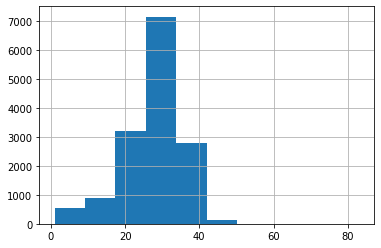

In [8]:
# On vérifie la distribution des ages pour créer des bins pertinents
df['age'].hist()

In [9]:
age_bins = [0, 9, 19, 29, 39, 49]
age_labels = ['0-9', '10-19', '20-29','30-39', '40-49']
df['age'] = pd.cut(df['age'], bins=age_bins, labels=age_labels)

In [10]:
by_age = df.fillna({'pcr_positive': 'not tested'}).groupby(['age', 'pcr_positive']).size().rename('count').reset_index()
by_age.head()

,age,pcr_positive,count
0,0-9,False,174
1,0-9,True,68
2,0-9,not tested,310
3,10-19,False,384
4,10-19,True,140


In [44]:
import plotly.express as px

fig = px.bar(
    by_age, x="age", y="count", color="pcr_positive",
    text='count', title="Nombre de patients testés",
    color_discrete_map={True: 'red', False: 'green', 'not tested': 'grey'},
)
fig.show()


In [12]:
testing_rate = (
    df.set_index('age')['pcr_positive'].notnull()
    .groupby('age').mean()
    .rename('Taux de test').reset_index()
)
testing_rate['label'] = testing_rate['Taux de test'].transform(lambda rate: f"{rate:.1%}")
testing_rate.head()

,age,Taux de test,label
0,0-9,0.438406,43.8%
1,10-19,0.456049,45.6%
2,20-29,0.457147,45.7%
3,30-39,0.454798,45.5%
4,40-49,0.444175,44.4%


In [13]:
px.bar(testing_rate, x="age", y="Taux de test", text='label', title="Fraction des patients ayant bénéficié d'un test PCR")

In [14]:
! pip install scipy

In [18]:
from scipy import stats

prevalence = (
    df.dropna(subset=['pcr_positive'])
    .groupby('age')
    .apply(lambda s: pd.Series({
        'n_tested': len(s),
        'Prévalence': stats.tmean(s['pcr_positive']),
        'incertitude': stats.tsem(s['pcr_positive']),
        'label': f"{s['pcr_positive'].mean():.1%}"
    }))
    .reset_index()
)

prevalence

,age,n_tested,Prévalence,incertitude,label
0,0-9,242,0.280992,0.028954,28.1%
1,10-19,524,0.267176,0.019349,26.7%
2,20-29,2955,0.248054,0.007946,24.8%
3,30-39,2787,0.257625,0.008285,25.8%
4,40-49,183,0.240437,0.031677,24.0%


In [21]:
px.scatter(
    prevalence, x="age", y="Prévalence", error_y='incertitude',
    range_y=[0, 0.35], # text="label",
    title="Taux de tests PCR positifs dans la population testée"
)


## Statistiques par état

- la distribution du nombre de patients par état semble correspondre à la population
- le taux de patients testés varie peu d'un état à l'autre et correspond à la moyenne nationale
- la prévalence varie peu d'un état à l'autre: environ 25%. Le *Northen Territory* semble avoir une prévalence bien
  plus faible mais nous disposons de trop peu de données dans cet état pour en tirer une réelle conclusion. L'état de *South Australia* a une prévalence légèrement plus faible à environ 23%.

<AxesSubplot:>

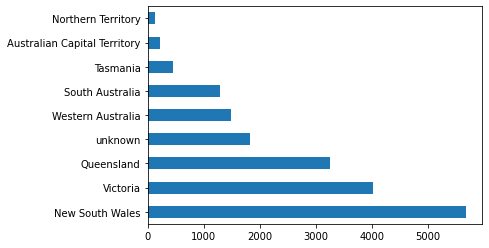

In [22]:
df['state'].fillna(value="unknown").value_counts().plot(kind='barh')

In [43]:
by_state = (
    df.fillna({'pcr_positive': 'not tested'})
    .groupby(['state', 'pcr_positive']).size()
    .rename('count').reset_index()
    .sort_values(by='state', ascending=False)
)
px.bar(
    by_state, y="state", x="count", color="pcr_positive",
    text='count', title="Nombre de patients testés",
    color_discrete_map={True: 'red', False: 'green', 'not tested': 'grey'},
)

In [31]:
testing_rate = (
    df.set_index('state')['pcr_positive'].notnull()
    .groupby('state').mean()
    .rename('Taux de test').reset_index()
    .sort_values(by='state', ascending=False)
    
)
testing_rate['label'] = testing_rate['Taux de test'].transform(lambda rate: f"{rate:.1%}")

px.bar(
    testing_rate, y="state", x="Taux de test",
    text='label',
    title="Fraction des patients ayant bénéficié d'un test PCR"
)

In [34]:
prevalence = (
    df.dropna(subset=['pcr_positive'])
    .groupby('state')
    .apply(lambda s: pd.Series({
        'n_tested': len(s),
        'Prévalence': stats.tmean(s['pcr_positive']),
        'incertitude': stats.tsem(s['pcr_positive']),
        'label': f"{s['pcr_positive'].mean():.1%}"
    }))
    .reset_index()
    .sort_values(by='state', ascending=False)
)

px.scatter(
    prevalence, y="state", x="Prévalence", error_x='incertitude',
    range_x=[0, 0.35], # text="label",
    title="Taux de tests PCR positifs dans la population testée"
)
